<h1>Opening a Food Cart in Portland, OR after the Pandemic</h1><br />
<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/5/5a/Food_carts_-_Portland%2C_Oregon_-_DSC01696.jpg" />
    <figcaption><i>By Daderot - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=72942046</i></figcaption>
</figure>
<hr />

<h2>Introduction/Business Problem</h2>
<p>
In the wake of the 2020 COVID-19 pandemic, many brick and mortar restaurants have been forced to close down due to revenue loss from the restrictions put in place to curb the spread of COVID-19. As such, independent restaurant ownership has a higher barrier to entry than ever before. A path forward for the independent restauranteur lies in the food cart scene, which has a large footprint in Portland, OR. Outside of reduced overall foot traffic, managing a food cart does not share many of the financial burdens of opening a restaurant that are so critically hampered by the uncertainties in revenue from reductions in customers and employees.
</p>
<p>
Given the large footprint in Portland, OR, competition can be fierce. The question becomes: where should you open a food cart to optimize customer engagement while minimizing competition?
</p>

<h2>Data</h2>

<p>
We will start with a list of neighborhoods in Portland, OR (derived from <a href="https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Portland,_Oregon">these data</a>) and use related data from Foursquare API calls to segment the city into clusters using a K-means algorithm. Based on population data and nearby attractions (especially food cart options), we will provide a top-five ranking of neighborhoods to select. 
</p>

<h2>Methodology</h2>

<p>We first use BeautifulSoup4 to parse the raw Wikipedia HTML into a list of dictionaries containing each neighborhood's name, latitude and longitude. This specific data structure will make it easy to convert to a pandas DataFrame. For each neighborhood, we also scrape its Wikipedia subpage for their latitude and longitude instead of utilizing a geocoder.</p>

In [103]:
from bs4 import BeautifulSoup
import numpy as np
import re
import requests

# Define default webpages.
RAW_HOME_LOC = 'https://en.wikipedia.org'
RAW_DATA_LOC = 'https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Portland,_Oregon'

# Grab the raw html data from the Wikipedia source and find all unordered lists in the 'mw-pages' div
# where the desired data is located.
r = requests.get(RAW_DATA_LOC)
soup = BeautifulSoup(r.content)
neigh_raw = soup.find('div', {'id': 'mw-pages'}).findAll('ul')

# The majority of the list elements are of the form: "<name>, Portland, Oregon", but a few are not, so we
# define a regexp to extract all text before the first comma, accounting for cases where there is none.
p = re.compile(r'^([^,])+')

# Compile a list of dictionaries containing neighborhoods and their latitudes and longitudes from their respective
# anchor href within each list element. The first entry of the unordered list is skipped because it is a subheader
# and not a neighborhood.
neigh_list = []

for ul in neigh_raw[1:]:
    for li in ul.findAll('li'):
        
        # Extract the neighborhood name
        name = re.match(p, li.text)[0]
        
        # Conveniently, each neighborhood has its own subpage in Wikipedia which references its latitude and
        # longitude. We use bs4 again to scrape these values for each neighborhood.
        url = RAW_HOME_LOC+li.a['href']
        sub_r = requests.get(url)
        sub_soup = BeautifulSoup(sub_r.content)
        lat, lng = sub_soup.find('span', {'class': 'geo'}).text.split('; ')
        
        # Scrape the page for the listed population density and convert it to a float. Set it to NaN if not found.
        try:
            density = sub_soup.find('th', text=re.compile(r'Density')).find_next_sibling('td').text.replace(',','')
            density_num = float(re.match(re.compile(r'[0-9]+'), density)[0])
        except AttributeError:
            density_num = np.NAN
        
        # Compile the dictionary and add it to the list of neighborhoods.
        neigh_list.append({'neighborhood': name, 'pop_density': density_num, 'lat': lat, 'lng': lng})

The list of dictionaries is easily converted to a pandas dataframe for ease of analysis using the pandas DataFrame from_dict method.

In [104]:
import pandas as pd

neigh_df = pd.DataFrame.from_dict(neigh_list)
neigh_df.head()

,neighborhood,pop_density,lat,lng
0,Alameda,8200.0,45.5482,-122.6307
1,Alberta Arts District,NaN,45.55905,-122.64286
2,Arbor Lodge,7000.0,45.57354,-122.69247
3,Ardenwald-Johnson Creek,NaN,45.4554,-122.6298
4,Argay,3100.0,45.55475,-122.52114


The Wikipedia scraping fails to find population densities for ten of the neighborhoods due to this value not existing on the subpages for these neighborhoods. For simplicity, we replace all NaNs with the mean population density.

In [107]:
neigh_df[neigh_df['pop_density'].isna()]['neighborhood'].count()

10

In [112]:
neigh_df[['pop_density']] = neigh_df[['pop_density']].fillna(pop_d_mean, axis=1)
neigh_df.head()

,neighborhood,pop_density,lat,lng
0,Alameda,8200.000000,45.5482,-122.6307
1,Alberta Arts District,5817.988764,45.55905,-122.64286
2,Arbor Lodge,7000.000000,45.57354,-122.69247
3,Ardenwald-Johnson Creek,5817.988764,45.4554,-122.6298
4,Argay,3100.000000,45.55475,-122.52114


<p>We display the results as a map using the Folium library, with marker size defined by the population density.</p>

In [4]:
import sys

# Install Folium
!{sys.executable} -m pip install -q folium

In [128]:
import folium

# Latitude and longitude of Portland, OR
base_lat_lng = [45.519947, -122.681936]

# Function to generate a marker scale size based on population density
def scale_marker_size(x, max_marker, min_marker, max_val, min_val):
    scale_factor = (max_marker-min_marker)/(max_val-min_val)
    return scale_factor*(x-min_val)+min_marker

max_pop = neigh_df['pop_density'].max()
min_pop = neigh_df['pop_density'].min()

# Initialize map
neigh_map = folium.Map(location=base_lat_lng, zoom_start=12)

# Add basic markers
for lat, lng, neighborhood, pop_d in zip(neigh_df['lat'],  neigh_df['lng'], neigh_df['neighborhood'], neigh_df['pop_density']):
    marker_radius = scale_marker_size(pop_d, 15, 3, max_pop, min_pop)
    tooltip = '{} (Pop. Density: {}/sq. mi.)'.format(neighborhood, pop_d)
    folium.CircleMarker([lat, lng], radius=marker_radius, tooltip=tooltip, color='black', fill=True, fill_opacity=0.5).add_to(neigh_map)

neigh_map

We make a call to the Fourquare API to gather categorical data of the top 100 nearby venues within 500m of the neighborhood center. 

In [6]:
# Define the Foursquare API call's default parameters. Client-specific keys are hidden.
VERSION = '20201101'
RADIUS = 500
LIMIT = 100

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
import json

def getNearbyVenues(df, version=VERSION, radius=RADIUS, limit=LIMIT):
    """
    Returns nearby venues from a dataframe consisting of neighborhoods, latitudes, and longitudes.
    """
    venues_list=[]
    
    for name, lat, lng in zip(df['neighborhood'], df['lat'], df['lng']):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            version,
            lat, 
            lng, 
            radius, 
            limit)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['shortName']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'lat', 
                  'lng', 
                  'venue', 
                  'venue_lat', 
                  'venue_lng', 
                  'venue_cat',
                  'venue_cat_short']
    
    return(nearby_venues)

In [12]:
venues = getNearbyVenues(neigh_df)

In [13]:
venues.head()

,neighborhood,lat,lng,venue,venue_lat,venue_lng,venue_cat,venue_cat_short
0,Alameda,45.5482,-122.6307,Marianne's,45.547526,-122.630483,Sports Bar,Sports Bar
1,Alameda,45.5482,-122.6307,TriMet Bus Line 24,45.548481,-122.630690,Bus Line,Bus
2,Alameda,45.5482,-122.6307,Joes Back Yard BBQ!,45.550229,-122.629402,BBQ Joint,BBQ
3,Alameda,45.5482,-122.6307,Tacovore,45.548444,-122.624638,Taco Place,Tacos
4,Alameda,45.5482,-122.6307,Beaux Berry,45.548367,-122.624389,Ice Cream Shop,Ice Cream


One-hot encoding of the venue categories is required for clustering later on. Back when the original venues dataset was pulled from the Foursquare API, the call failed to return venues for the three neighborhoods below. Thus, we will exclude them from the analysis.

In [130]:
venues_ohe = pd.get_dummies(venues[['venue_cat']], prefix='', prefix_sep='')
venues_ohe['neighborhood'] = venues['neighborhood'] 
venues_ohe = venues_ohe.groupby('neighborhood').mean().reset_index()

neigh_venues = neigh_df.join(venues_ohe.set_index('neighborhood'), on='neighborhood')

In [131]:
neigh_venues[neigh_venues.isna().any(axis=1)]

,neighborhood,pop_density,lat,lng,ATM,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,...,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
12,Bridlemile,4100.0,45.4931737,-122.7103744,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Forest Park,220.0,45.53476,-122.74119,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,St. Johns,1000.0,45.61259,-122.76287,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
neigh_venues.dropna(inplace=True)

For our feature set, we select population density, latitude, longitude, and encoded "Food Truck" values.

In [157]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Subset the full DataFrame prior to scaling.
neigh_sub = neigh_venues[['neighborhood','pop_density','lat','lng','Food Truck']]
neigh_sub.head()

,neighborhood,pop_density,lat,lng,Food Truck
0,Alameda,8200.000000,45.5482,-122.6307,0.000000
1,Alberta Arts District,5817.988764,45.55905,-122.64286,0.033898
2,Arbor Lodge,7000.000000,45.57354,-122.69247,0.071429
3,Ardenwald-Johnson Creek,5817.988764,45.4554,-122.6298,0.000000
4,Argay,3100.000000,45.55475,-122.52114,0.000000


The ML algorithm used for this analysis is an unsupervised KMeans clustering. We consider both the SSE and Silhouette Score to determine the optimum number of clusters.

In [158]:
# Convert DataFrame to NumPy array for use with the sklearn package.
neigh_val = neigh_sub.drop('neighborhood', axis=1)
neigh_val = neigh_val.values

# Pre-process using StandardScaler
scaler = StandardScaler()
neigh_scale = scaler.fit_transform(neigh_val)

In [155]:
sse = []
silhouette_coefficients = []
labels = {}

# Arbitrary choice of maximum num. of clusters to start
max_clusters = 20

# Silhouette score requires a minimum of two clusters
for k in range(2, max_clusters):
    kmeans = KMeans(init='k-means++', n_init=12, n_clusters=k)
    kmeans.fit(neigh_scale)
    
    # Load predictions into memory for later retrieval once optimum k is determined
    labels[k] = kmeans.predict(neigh_scale)
    
    # Add SSE
    sse.append(kmeans.inertia_)
    
    # Calculate and add Silhouette Score
    score = silhouette_score(neigh_scale, kmeans.labels_)
    silhouette_coefficients.append(score)

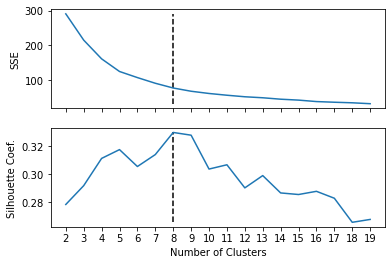

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline

# Subplots to share x-axis (num. of clusters)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
x_range = range(2, max_clusters)
plt.xticks(range(2, max_clusters))
plt.xlabel("Number of Clusters")

# Plot SSE
ax1.plot(x_range, sse)
ax1.vlines(8, min(sse), max(sse), colors='k', linestyles='dashed')
ax1.set_ylabel("SSE")

# Plot Silhouette Scores
ax2.plot(x_range, silhouette_coefficients)
ax2.vlines(8, min(silhouette_coefficients), max(silhouette_coefficients), colors='k', linestyles='dashed')
ax2.set_ylabel("Silhouette Coef.")

plt.show()

The results suggest an optimum cluster number is eight. Our prior map can now be updated with the cluster labels.

In [190]:
from matplotlib import colors
import seaborn as sns

# Create a copy of the venues subset and add the labels from the clustering results
neigh_label = neigh_sub.copy(deep=True)
neigh_label['label'] = pd.Series(labels[8], index=neigh_sub.index)

# Initialize cluster map
cluster_map = folium.Map(location=base_lat_lng, zoom_start=12)

# Define color palette for cluster labels
colors = [colors.rgb2hex(i) for i in sns.color_palette()]

# Add basic markers
for lat, lng, neighborhood, pop_d, label in zip(neigh_label['lat'], neigh_label['lng'], neigh_label['neighborhood'], neigh_label['pop_density'], neigh_label['label']):
    marker_radius = scale_marker_size(pop_d, 15, 3, max_pop, min_pop)
    tooltip = '{} (Pop. Density: {}/sq. mi.)'.format(neighborhood, pop_d)
    folium.CircleMarker([lat, lng], radius=marker_radius, tooltip=tooltip, color=colors[label], fill=True, fill_opacity=0.5).add_to(cluster_map)

cluster_map

We plot the final dataset showing how each cluster ranks in terms of Population Density and fraction of venues that are food trucks within 500m of the neighborhood centers are food trucks (with maximum possible venues equal to 100).

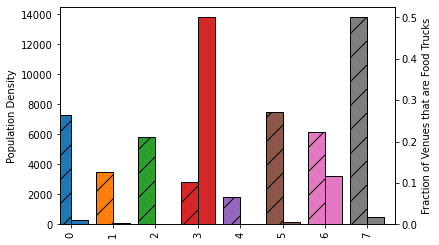

In [188]:
neigh_means = neigh_label.groupby('label').mean().reset_index()

fig = plt.figure()

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

neigh_means.pop_density.plot(kind='bar', edgecolor='black', color=colors, hatch='/', ax=ax, width=width, position=1)
neigh_means['Food Truck'].plot(kind='bar', edgecolor='black', color=colors, ax=ax2, width=width, position=0)

ax.set_ylabel('Population Density')
ax2.set_ylabel('Fraction of Venues that are Food Trucks')

plt.show()